# Sentiment Analysis by Subtheme per Agreement level

In [2]:
# Change working directory to be project root
import os
#os.chdir("..")
os.getcwd()

'C:\\Users\\payla\\Documents\\MDS\\Capstone\\DSCI_591_capstone-BCStats'

In [3]:
import pandas as pd
import numpy as np
import time

import spacy
# Load English model for SpaCy
nlp = spacy.load('en_core_web_sm')

In [4]:
# ensure packages reload after every change 
%load_ext autoreload
%autoreload 2
import src

from src.emotion_analysis import *
from src.data.preprocessing_text import to_lowercase

## Load Data and Lexicon

In [5]:
# read in data about subthemes
df = pd.read_csv(".\data\interim\joined_qual_quant.csv")
df.head(3)

,USERID,code,qual_value,quan_value,question,diff,text
0,175125-215928,43,-1,-1,Q63,0,The problem with the BCSS is Linda Cavanaugh a...
1,175125-215928,43,-1,-1,Q65,0,The problem with the BCSS is Linda Cavanaugh a...
2,191202-862188,102,-1,-1,Q39,0,"Improved office space (fix HVAC, etc) but NO LWS"


In [6]:
# Lexicon from "http://saifmohammad.com/WebDocs/NRC-AffectIntensity-Lexicon.txt"
lexicon = pd.read_csv("http://saifmohammad.com/WebDocs/NRC-AffectIntensity-Lexicon.txt", 
                      sep="\t", 
                      skiprows=35) 
# create dataframes for each emotions 
anger = lexicon[lexicon['AffectDimension']=='anger']
fear = lexicon[lexicon['AffectDimension']=='fear']
sad = lexicon[lexicon['AffectDimension']=='sadness']
joy = lexicon[lexicon['AffectDimension']=='joy']

## Create Rules for Matcher

In [7]:
match_anger = src.emotion_analysis.create_emotion_matcher(anger)
match_fear = src.emotion_analysis.create_emotion_matcher(fear)
match_sad = src.emotion_analysis.create_emotion_matcher(sad)
match_joy = src.emotion_analysis.create_emotion_matcher(joy)

## Create Dataframe for Each Subtheme and Agreement Level

In [8]:
# convert text to lower case
df["text"] = df['text'].apply(src.data.preprocessing_text.to_lowercase)
df.head(3)

,USERID,code,qual_value,quan_value,question,diff,text
0,175125-215928,43,-1,-1,Q63,0,the problem with the bcss is linda cavanaugh a...
1,175125-215928,43,-1,-1,Q65,0,the problem with the bcss is linda cavanaugh a...
2,191202-862188,102,-1,-1,Q39,0,"improved office space (fix hvac, etc) but no lws"


In [9]:
start = time.time()
comments = df["text"]
# create SpaCy tokens
docs = [nlp(comment) for comment in comments]
end = time.time()
print((end - start) / 60, "mins")

6.840245831012726 mins


In [10]:
start = time.time()
# add the emotion scores to data
df["anger"] = src.emotion_analysis.emotion_strength(docs, match_anger, anger)
df["fear"] = src.emotion_analysis.emotion_strength(docs, match_fear, fear)
df["sad"] = src.emotion_analysis.emotion_strength(docs, match_sad, sad)
df["joy"] = src.emotion_analysis.emotion_strength(docs, match_joy, joy)

end = time.time()
print((end - start) / 60, "mins")
display(df.head(3))

5.341811641057332 mins


,USERID,code,qual_value,quan_value,question,diff,text,anger,fear,sad,joy
0,175125-215928,43,-1,-1,Q63,0,the problem with the bcss is linda cavanaugh a...,1.851,2.478,2.578,0.79
1,175125-215928,43,-1,-1,Q65,0,the problem with the bcss is linda cavanaugh a...,1.851,2.478,2.578,0.79
2,191202-862188,102,-1,-1,Q39,0,"improved office space (fix hvac, etc) but no lws",0.000,0.000,0.000,0.00


## Add Main Theme Names

In [11]:
# get names of main themes 
df = src.emotion_analysis.get_main_theme_codes(df, "main_theme")
df["main_theme"] = df["main_theme"].apply(src.emotion_analysis.get_main_theme_label)
df.head(3)

,USERID,code,qual_value,quan_value,question,diff,text,anger,fear,sad,joy,main_theme
0,175125-215928,43,-1,-1,Q63,0,the problem with the bcss is linda cavanaugh a...,1.851,2.478,2.578,0.79,Executives
1,175125-215928,43,-1,-1,Q65,0,the problem with the bcss is linda cavanaugh a...,1.851,2.478,2.578,0.79,Executives
2,191202-862188,102,-1,-1,Q39,0,"improved office space (fix hvac, etc) but no lws",0.000,0.000,0.000,0.00,"Tools, Equipment & Physical Environment"


### View plots

C:\Users\payla\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


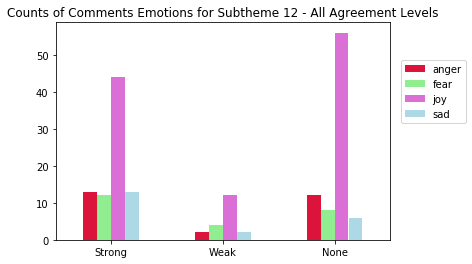

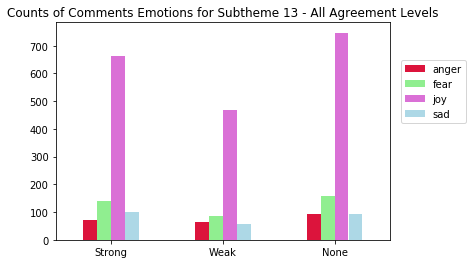

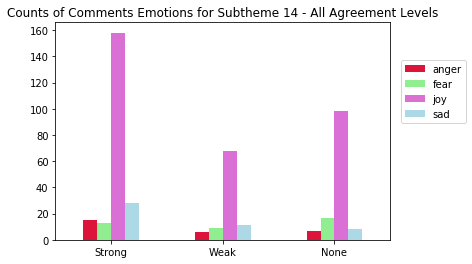

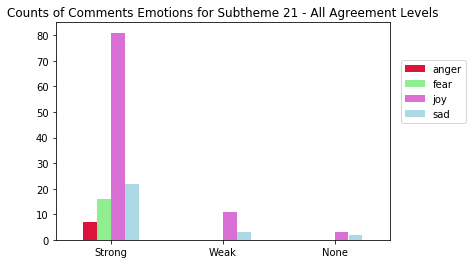

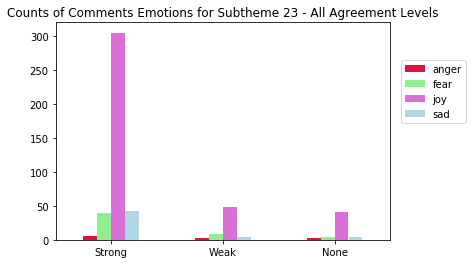

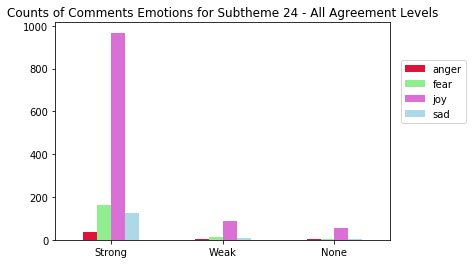

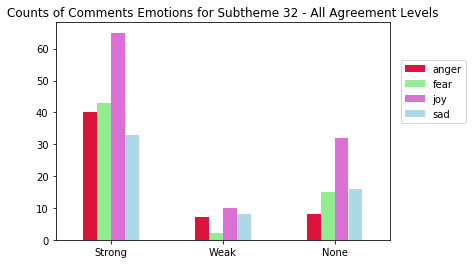

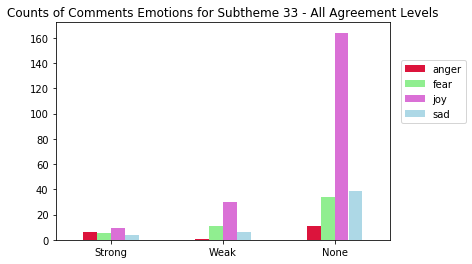

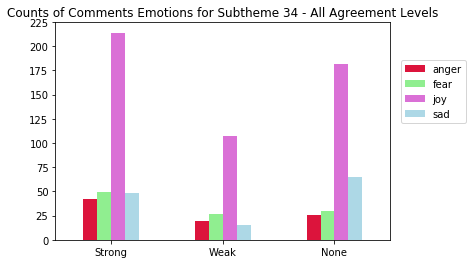

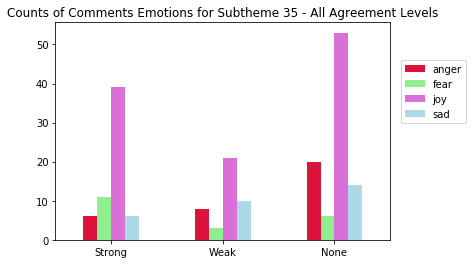

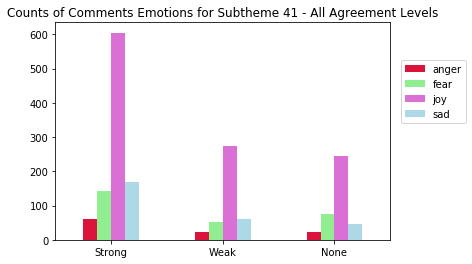

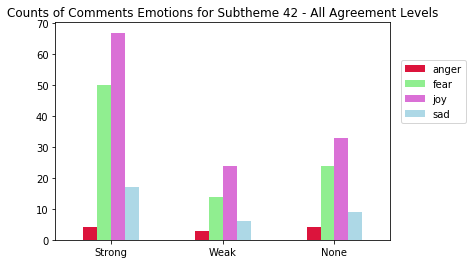

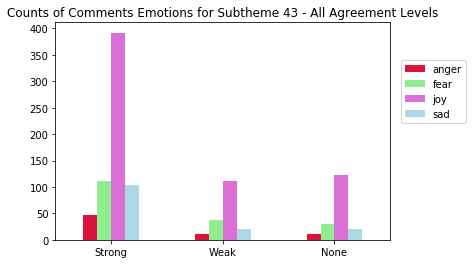

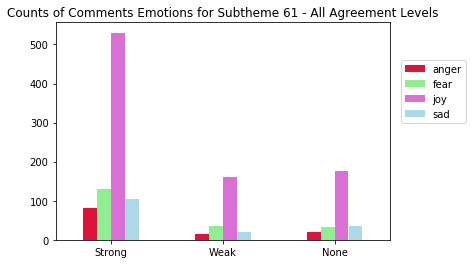

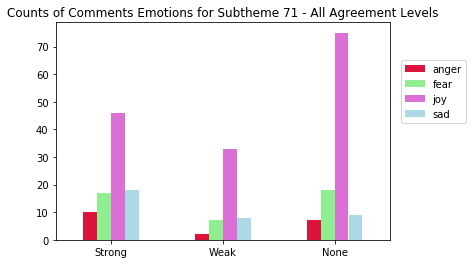

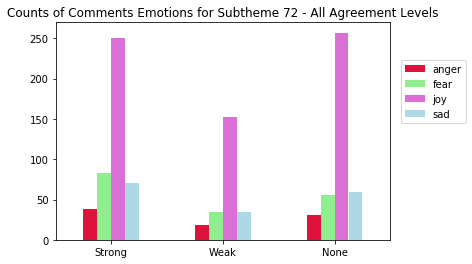

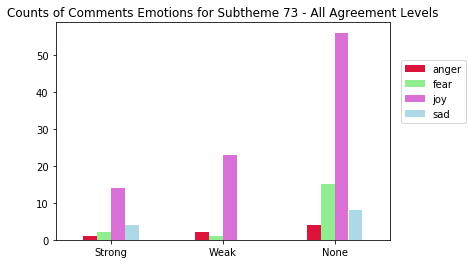

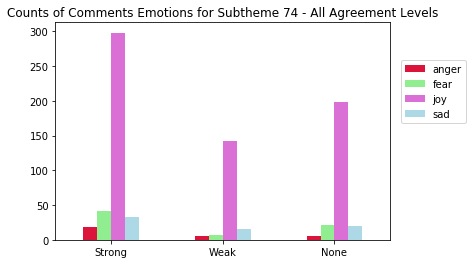

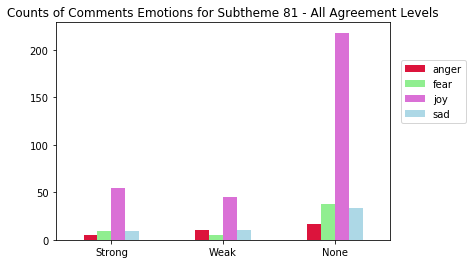

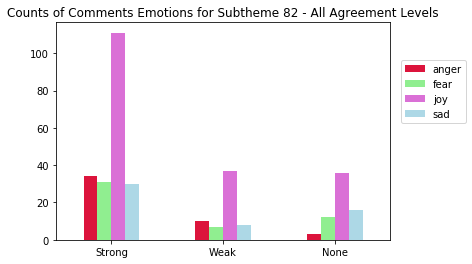

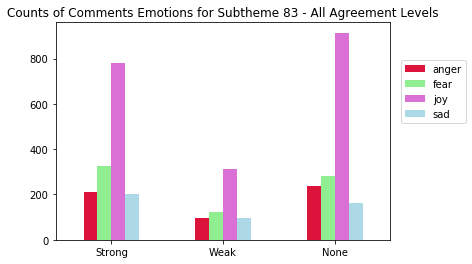

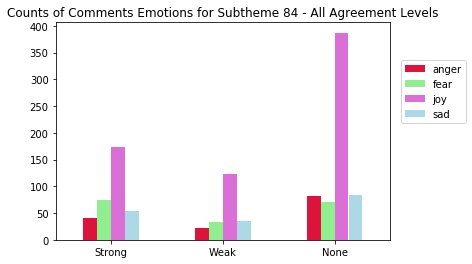

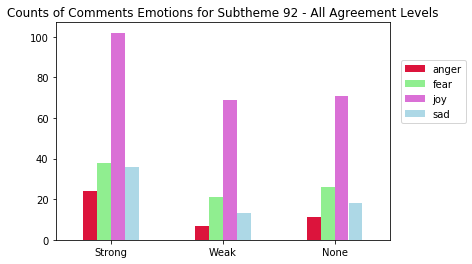

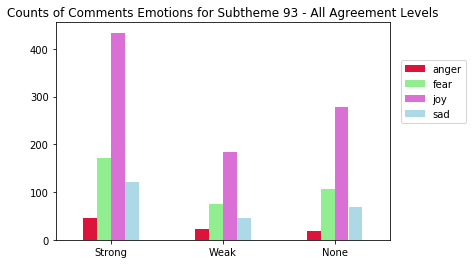

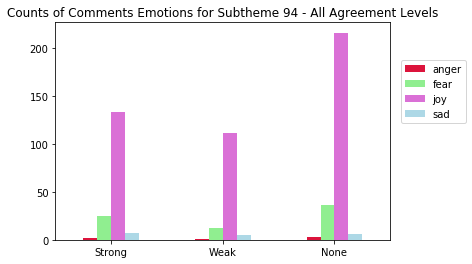

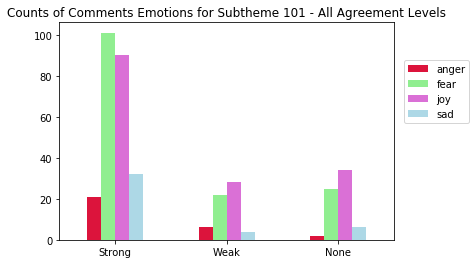

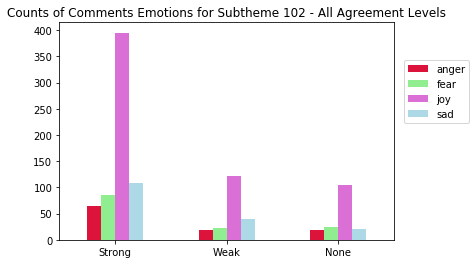

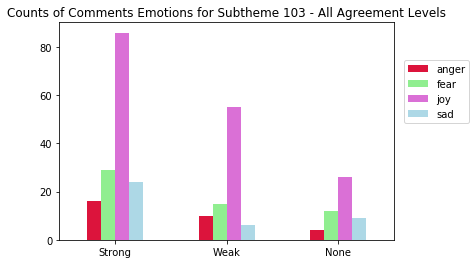

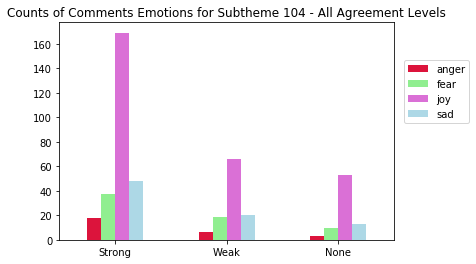

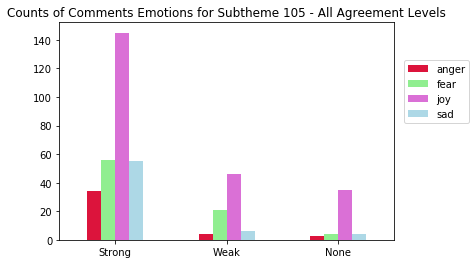

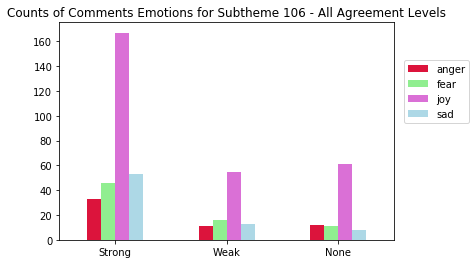

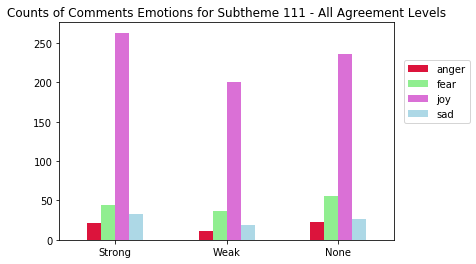

In [13]:
codes = np.sort(df['code'].unique())
for i in codes:
    src.emotion_analysis.plot_data("subtheme", i, "all", df)

### Observations from subtheme level analysis

- joy is the most common emotion for all subthemes and agreement levels 
  - this seems to be due to the only words in the comment being happy
      - might be worth aggregating all of the sentences together and then doing the comparison
  - the other main reseson is the words are just with a negative context and since this is only matching words it doesn't understand the meaning
      - might be worth removing joy all together because it doesn't really match well
      
- a good set of the comments match to the emotion
    - Could manually score a small set of them to get an "accuracy" score
    - bit of weirdness due to context, government is one of the words in the lexicon and it is being used as a name compared to an emotion. Same with words like leave since it relates to time off not leaving often

- there are over 5000 comments that have no related emotion

- this seems counterintuitive
- subtheme 35, 82, 105
  - anger as dominant as joy in no agreement 
  - not since I made the adjustment to remove the emotionless comments
- subtheme 42, 101
  - fear is dominant as fear in strong agreement 
  

In [14]:
src.emotion_analysis.examine_emotion_scoring(df, "sad", lexicon)

,USERID,code,diff,text,anger,fear,sad,joy,c_anger,c_fear,c_sad,c_joy
9680,189975-302088,61,0,because most management and excluded positions...,0.782,0.0,1.855,0.188,0,0,1,0



Comment 
 because most management and excluded positions are filled based on personal preferences and not by merit, the least one can do is at least have psa provide training to these 'leaders' in basics such as  basic management principles and hr policies. this would go a long way in limiting the damage they cause as they are doing their trial and error or simply letting the staff fall through the gaps and walking away from the mess.


ANGER
-----
management 0.102
management 0.102
damage 0.578


FEAR
----


SAD
---
excluded 0.609
damage 0.578
error 0.250
fall 0.418


JOY
---
walking 0.188


In [15]:
# total number of comments is higher because there are duplicates 
# since comments relate to multiple mc questions
src.emotion_analysis.summary_number_comment(df, 0.3, include=True)
src.emotion_analysis.summary_number_comment(df, 0.5)
src.emotion_analysis.summary_number_comment(df, 1)
src.emotion_analysis.summary_number_comment(df, 2)
src.emotion_analysis.summary_number_comment(df, 5)

Total Number of Comments 31299
Remaining comments when all 4 emotions are zero 26041
Where joy is the only emotion with a score 6023
Number of comments 1553 with only joy and a sum score less than 0.3
Number of comments 2869 with only joy and a sum score less than 0.5
Number of comments 4857 with only joy and a sum score less than 1
Number of comments 5830 with only joy and a sum score less than 2
Number of comments 6023 with only joy and a sum score less than 5


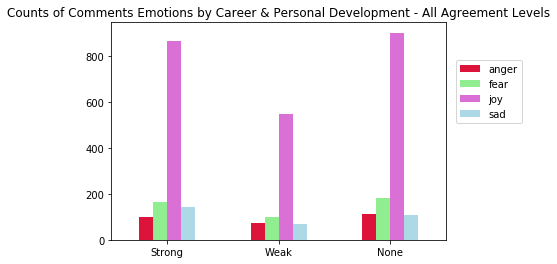

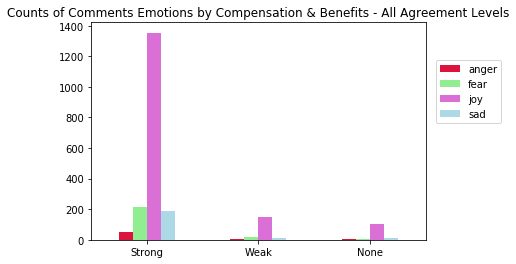

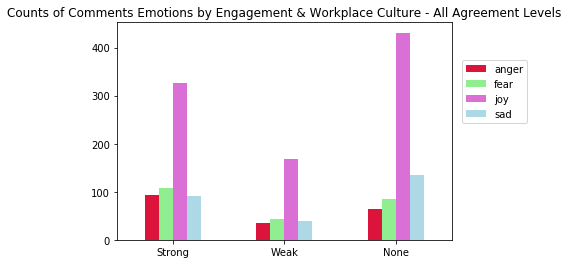

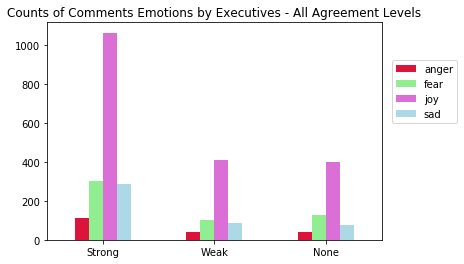

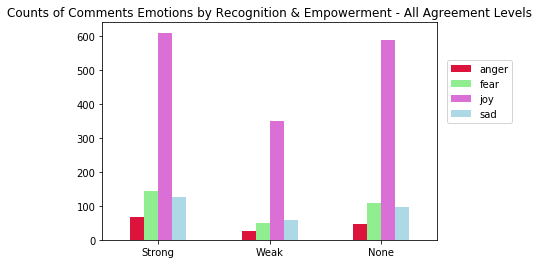

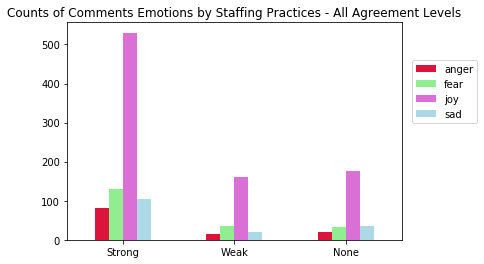

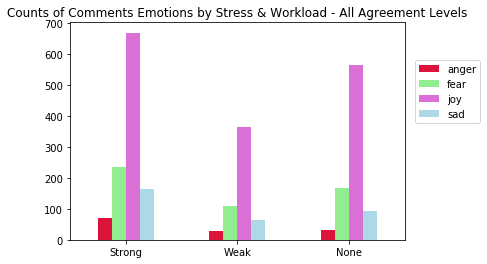

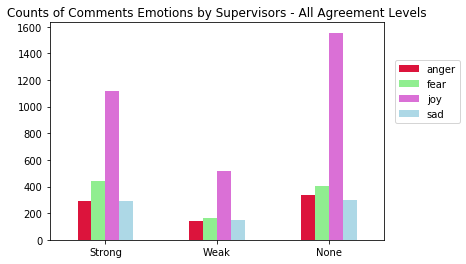

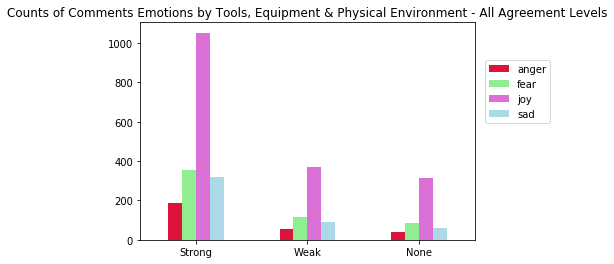

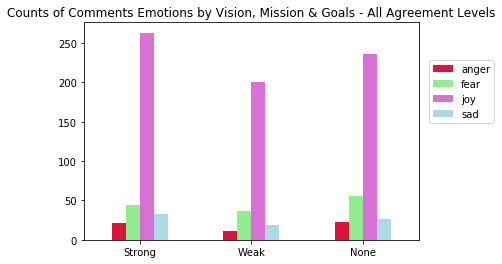

In [16]:
labels = np.sort(df['main_theme'].unique())
for i in labels:
    src.emotion_analysis.plot_data("theme", i, "all", df)